# EEA Grid Assignment for each datapoint
To discretize the latitude-longitude data, we aim to assign each bird sightings to a grid cell of the official EEA-Grid for Europe. Online ([here](https://www.eea.europa.eu/en/datahub/datahubitem-view/3c362237-daa4-45e2-8c16-aaadfb1a003b)), grid sizes of 1km, 5km, 10km, and 100km are available. As a compromise between grid size and computational complexity, we have chosen a grid size of 10x10km.

In this notebook, the dataset, which has been reduced to 27 species, assigns each data point to a grid and stores it as an extra feature.

In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [19]:
data_path = '/Users/marinasiebold/Library/Mobile Documents/com~apple~CloudDocs/Studium/Bird_Research/01_Data/master_bird_data_selected_species.csv'  # Provide path to csv file 'master_bird_data_selected_species.csv'
eea_shapefile_path = '/Users/marinasiebold/Library/Mobile Documents/com~apple~CloudDocs/Studium/Bird_Research/01_Data/eea_grid_europe_10km/Grid_ETRS89-LAEA_10K.shp'

In [3]:
df = pd.read_csv(data_path, index_col=0, low_memory=False)

In [44]:
eea_grid = gpd.read_file(eea_shapefile_path)

### Align Coordinate Reference System (CRS) of bird sightings and EEA grids
The EEA grid is specified in the CRS EPSG:3035:

In [30]:
eea_grid.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

EPSG:3035 is a projected coordinate reference system used for Europe. It is based on the European Terrestrial Reference System 1989 (ETRS89) and uses the Lambert Azimuthal Equal Area (LAEA) projection. This projection minimizes distortion for area measurements but may distort shapes and angles in favor of maintaining accurate area representations. EPSG:3035 uses meters as its unit of measurement.

However, our bird sightings are specified in the CRS WGS84. WGS84 is a global geodetic datum commonly used to represent locations on the Earth's surface using latitude and longitude coordinates. The EPSG code for WGS84 is EPSG:4326.

In order to ensure proper alignment, we need to perform a coordinate transformation of the EEA grids to EPSG:4326 (WGS84):


In [48]:
eea_grid = eea_grid.to_crs("EPSG:4326")
eea_grid

,CellCode,EofOrigin,NofOrigin,geometry
0,10kmE0N70,0,700000,"POLYGON ((-31.18478 18.79810, -31.21799 18.879..."
1,10kmE1N70,10000,700000,"POLYGON ((-31.09824 18.84459, -31.13141 18.925..."
2,10kmE2N70,20000,700000,"POLYGON ((-31.01165 18.89098, -31.04480 18.972..."
3,10kmE3N70,30000,700000,"POLYGON ((-30.92503 18.93727, -30.95814 19.018..."
4,10kmE4N70,40000,700000,"POLYGON ((-30.83836 18.98347, -30.87144 19.064..."


### Assign an EEA grid cell to each datapoint in our ornitho dataset
In the following, the coordinates of each bird sighting are assigned to a grid and noted in a new column in the dataset.<br>
By using the spatial index `sindex``, we limit the number of grid cells to check for each point to only those that intersect with the point's bounding box. This significantly reduces the number of comparisons and speeds up the assignment process.

In [71]:
germany_switzerland_bbox = eea_grid.cx[5.210942:15.669926, 45.614516:55.379499]
eea_grid_filtered = eea_grid[eea_grid.intersects(germany_switzerland_bbox.unary_union)]
eea_grid_filtered.reset_index(drop=True, inplace=True)

In [97]:
geometry = gpd.points_from_xy(df['coord_lon'], df['coord_lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

joined_gdf = gpd.sjoin(gdf, eea_grid_filtered, how='left', predicate='within')
joined_gdf.rename(columns={'CellCode': 'eea_grid_id'}, inplace=True)
result_gdf = joined_gdf.drop(columns=['index_right', 'geometry', 'NofOrigin', 'EofOrigin'])

In [98]:
result_gdf

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
14,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,0,0.0,NaN,37718.0,de,10kmE423N333
17,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0,2.0,NaN,37803.0,de,10kmE425N333
30,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,0,2.0,NaN,39627.0,de,10kmE447N308
49,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,0,8.0,NaN,38301.0,de,10kmE439N310
77,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,0,10.0,NaN,108167.0,de,10kmE411N314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9922826,27523548,469.0,Bergpieper,2022-08-01,09:35:04,46.563896,8.551648,precise,2085,4.0,0,11482.0,ch,10kmE420N260
9922833,27523686,338.0,Mittelspecht,2022-10-08,09:17:16,47.383318,7.666533,precise,798,1.0,0,11482.0,ch,10kmE414N269
9922862,15002272,123.0,Bergente,2018-02-17,NaN,47.512154,9.436332,precise,390,1.0,0,11245.0,ch,10kmE427N271
9922867,15002282,8.0,Haubentaucher,2018-02-17,NaN,47.512154,9.436332,precise,390,NaN,0,11245.0,ch,10kmE427N271


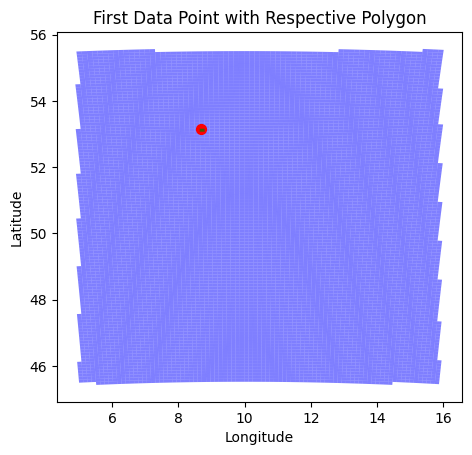

In [104]:
import matplotlib.pyplot as plt

first_data_point = result_gdf.iloc[0]  # Extract the first row of the DataFrame
geometry = gpd.points_from_xy([first_data_point['coord_lon']], [first_data_point['coord_lat']])
gdf_data_point = gpd.GeoDataFrame([first_data_point], geometry=geometry, crs="EPSG:4326")

# Step 2: Locate the corresponding polygon in the GeoDataFrame
eea_grid_id = first_data_point['eea_grid_id']
polygon = eea_grid_filtered[eea_grid_filtered['CellCode'] == eea_grid_id]['geometry'].iloc[0]

# Step 3: Plot the polygon and the data point on a map
fig, ax = plt.subplots()
eea_grid_filtered.plot(ax=ax, color='blue', alpha=0.5)  # Plot all polygons in blue with 50% transparency
gdf_data_point.plot(ax=ax, color='red', markersize=50)  # Plot the data point in red with marker size 50

# Plot the specific polygon that corresponds to the first data point in green with 70% transparency
gpd.GeoSeries(polygon).plot(ax=ax, color='green', alpha=0.7)

# Optional: Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('First Data Point with Respective Polygon')

# Show the plot
plt.show()

In [108]:
import plotly.express as px

first_data_point = result_gdf.iloc[0]  # Extract the first row of the DataFrame
geometry = gpd.points_from_xy([first_data_point['coord_lon']], [first_data_point['coord_lat']])
gdf_data_point = gpd.GeoDataFrame([first_data_point], geometry=geometry, crs="EPSG:4326")

# Step 2: Locate the corresponding polygon in the GeoDataFrame
eea_grid_id = first_data_point['eea_grid_id']
polygon = eea_grid_filtered[eea_grid_filtered['CellCode'] == eea_grid_id]['geometry'].iloc[0]

fig = px.choropleth_mapbox(eea_grid_filtered, geojson=eea_grid_filtered.geometry.__geo_interface__,
                           locations='CellCode', featureidkey="properties.eea_grid_id",
                           color_discrete_sequence=['blue'],
                           opacity=0.5,
                           hover_data=['CellCode'])

fig.add_trace(px.scatter_mapbox(gdf_data_point,
                 lat='coord_lat', lon='coord_lon', hover_name='eea_grid_id', size_max=10).data[0])

fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=5,
                  mapbox_center={"lat": first_data_point['coord_lat'], "lon": first_data_point['coord_lon']})

# Show the plot
fig.show()

NameError: name 'gdf_polygon' is not defined

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2660043 entries, 14 to 9922871
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id_sighting   int64  
 1   id_species    float64
 2   name_species  object 
 3   date          object 
 4   timing        object 
 5   coord_lat     float64
 6   coord_lon     float64
 7   precision     object 
 8   altitude      int64  
 9   total_count   float64
 10  atlas_code    object 
 11  id_observer   float64
 12  country       object 
dtypes: float64(5), int64(2), object(6)
memory usage: 284.1+ MB
